In [3]:
import numpy as np
import sympy as sym
import pydae.build_cffi as db

In [155]:
tau_d = 0.01
L_ls = 0.01
R_s = 0.01
L_lr = 0.01
R_r = 0.01
L_m = 1.0

K_p = L_ls/tau_d
K_i = R_s/tau_d
params_dict = {'L_m':L_m,
               'R_s':R_s,'L_ls':L_ls,
               'R_r':R_r,'L_lr':L_lr,               
               'N_pp':2.0,'K_theta':1e-8,
               'J_r':1.0, 'B_r':0.1,
               'K_p':K_p,'K_i':K_i,
              }

## Electromagnetic abc

In [156]:
# im:
u_ini_dict = {'v_sa':0.0,'v_sb':0.0,'v_sc':0.0,'tau_l':0,'omega':0}  # for the initialization problem
u_run_dict = {'v_sa':0.0,'v_sb':0.0,'v_sc':0.0,'tau_l':0,'omega':0}  # for the running problem (here initialization and running problem are the same)

lambda_sd,lambda_sq,lambda_rd,lambda_rq,omega_r = sym.symbols('lambda_sd,lambda_sq,lambda_rd,lambda_rq,omega_r', real=True)
v_sa,v_sb,v_sc,tau_l,omega = sym.symbols('v_sa,v_sb,v_sc,tau_l,omega', real=True) 
tau_r = sym.Symbol('tau_r', real=True) 
L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i = sym.symbols('L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i', real=True)
theta,K_theta = sym.symbols('theta,K_theta', real=True) 
  
v_sd = 2/3*(sym.cos(theta)*v_sa + sym.cos(theta-2/3*np.pi)*v_sb + sym.cos(theta-4/3*np.pi)*v_sc) 
v_sq = 2/3*(sym.sin(theta)*v_sa + sym.sin(theta-2/3*np.pi)*v_sb + sym.sin(theta-4/3*np.pi)*v_sc) 

L_s  =  L_m + L_ls
L_r  =  L_m + L_lr 
omega_e = N_pp*omega_r
i_sd = (L_m * lambda_rd - L_r * lambda_sd)/(L_m**2 - L_r * L_s)
i_sq = (L_m * lambda_rq - L_r * lambda_sq)/(L_m**2 - L_r * L_s)
i_rd = (L_m * lambda_sd - L_s * lambda_rd)/(L_m**2 - L_r * L_s)
i_rq = (L_m * lambda_sq - L_s * lambda_rq)/(L_m**2 - L_r * L_s)

dlambda_sd = v_sd - R_s * i_sd + omega * lambda_sq
dlambda_sq = v_sq - R_s * i_sq - omega * lambda_sd
dlambda_rd = -R_r * i_rd + (omega - omega_e) * lambda_rq 
dlambda_rq = -R_r * i_rq - (omega - omega_e) * lambda_rd
dtheta = omega - K_theta*theta

eq_tau_r = -tau_r + 3/2* N_pp * (lambda_sd *  i_sq - lambda_sq * i_sd)
#eq_v_sd = -tau_r + 3/2* N_pp * (lambda_sd *  i_sq - lambda_sq * i_sd)
#eq_v_sq = 

# mech:
domega_r = 1/J_r*(tau_r - B_r*omega_r - tau_l)

i_sa = sym.cos(theta)*i_sd + sym.sin(theta)*i_sq
i_sb = sym.cos(theta-2/3*np.pi)*i_sd + sym.sin(theta-2/3*np.pi)*i_sq
i_sc = sym.cos(theta-4/3*np.pi)*i_sd + sym.sin(theta-4/3*np.pi)*i_sq

f_list = [dlambda_sd,dlambda_sq,dlambda_rd,dlambda_rq,domega_r,dtheta]
x_list = [ lambda_sd, lambda_sq, lambda_rd, lambda_rq, omega_r, theta]
g_list = [eq_tau_r]
y_list = [   tau_r]

p_s = 3/2*(i_sq*v_sq + i_sd*v_sd)
q_s = 3/2*(i_sd*v_sq - i_sq*v_sd)

h_dict = {'i_sd':i_sd,'i_sq':i_sq,'i_rd':i_rd,'i_rq':i_rq,'i_pk':(i_sd**2+i_sq**2)**0.5,
          'tau_b':B_r*omega_r,'tau_l':tau_l,
         'p_s':p_s,'q_s':q_s,
         'v_sd':v_sd,'v_sq':v_sq,
         'i_sa':i_sa,'i_sb':i_sb,'i_sc':i_sc,
         'v_sa':v_sa,'v_sb':v_sb,'v_sc':v_sc}

In [157]:
sys = {'name':f"im_emag_abc",
       'params_dict':params_dict,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_run_dict,
       'u_ini_dict':u_ini_dict,
       'h_dict':h_dict
      }

bldr = db.builder(sys)
bldr.build()

Compilation time: 3.02 s


## Electromagnetic dq

In [158]:
u_ini_dict = {'v_sd':0.0,'v_sq':0.0,'tau_l':0,'omega':0}
u_run_dict = {'v_sd':0.0,'v_sq':0.0,'tau_l':0,'omega':0}

v_sd,v_sq = sym.symbols('v_sd,v_sq', real=True) 

dlambda_sd = v_sd - R_s * i_sd + omega * lambda_sq
dlambda_sq = v_sq - R_s * i_sq - omega * lambda_sd

f_list = [dlambda_sd,dlambda_sq,dlambda_rd,dlambda_rq,domega_r]
x_list = [ lambda_sd, lambda_sq, lambda_rd, lambda_rq, omega_r]
g_list = [eq_tau_r]
y_list = [   tau_r]

p_s = 3/2*(i_sq*v_sq + i_sd*v_sd)
q_s = 3/2*(i_sd*v_sq - i_sq*v_sd)

h_dict = {'i_sd':i_sd,'i_sq':i_sq,'i_rd':i_rd,'i_rq':i_rq,'i_pk':(i_sd**2+i_sq**2)**0.5,
          'tau_b':B_r*omega_r,'tau_l':tau_l,
         'p_s':p_s,'q_s':q_s, 'v_sd':v_sd,'v_sq':v_sq}

sys = {'name':f"im_emag_dq",
       'params_dict':params_dict,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_run_dict,
       'u_ini_dict':u_ini_dict,
       'h_dict':h_dict
      }

bldr = db.builder(sys)
bldr.build()

Compilation time: 2.85 s


In [20]:
h_dict

{'i_sd': (L_m*lambda_rd - lambda_sd*(L_lr + L_m))/(L_m**2 - (L_lr + L_m)*(L_ls + L_m)),
 'i_sq': (L_m*lambda_rq - lambda_sq*(L_lr + L_m))/(L_m**2 - (L_lr + L_m)*(L_ls + L_m)),
 'i_rd': (L_m*lambda_sd - lambda_rd*(L_ls + L_m))/(L_m**2 - (L_lr + L_m)*(L_ls + L_m)),
 'i_rq': (L_m*lambda_sq - lambda_rq*(L_ls + L_m))/(L_m**2 - (L_lr + L_m)*(L_ls + L_m)),
 'i_pk': ((L_m*lambda_rd - lambda_sd*(L_lr + L_m))**2/(L_m**2 - (L_lr + L_m)*(L_ls + L_m))**2 + (L_m*lambda_rq - lambda_sq*(L_lr + L_m))**2/(L_m**2 - (L_lr + L_m)*(L_ls + L_m))**2)**0.5,
 'tau_b': B_r*omega_r,
 'tau_l': tau_l,
 'p_s': 1.5*(L_m*lambda_rd - lambda_sd*(L_lr + L_m))*(0.666666666666667*v_sa*cos(theta) + 0.666666666666667*v_sb*cos(theta - 2.0943951023932) + 0.666666666666667*v_sc*cos(theta - 4.18879020478639))/(L_m**2 - (L_lr + L_m)*(L_ls + L_m)) + 1.5*(L_m*lambda_rq - lambda_sq*(L_lr + L_m))*(0.666666666666667*v_sa*sin(theta) + 0.666666666666667*v_sb*sin(theta - 2.0943951023932) + 0.666666666666667*v_sc*sin(theta - 4.18879020478

In [ ]:
# im:
u_ini_dict = {'v_sa':0.0,'v_sb':0.0,'v_sc':0.0,'tau_l':0,'omega':0}  # for the initialization problem
u_run_dict = {'v_sa':0.0,'v_sb':0.0,'v_sc':0.0,'tau_l':0,'omega':0}  # for the running problem (here initialization and running problem are the same)

lambda_sd,lambda_sq,lambda_rd,lambda_rq,omega_r = sym.symbols('lambda_sd,lambda_sq,lambda_rd,lambda_rq,omega_r', real=True)
v_sa,v_sb,v_sc,tau_l,omega = sym.symbols('v_sa,v_sb,v_sc,tau_l,omega', real=True) 
tau_r = sym.Symbol('tau_r', real=True) 
L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i = sym.symbols('L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i', real=True)
theta,K_theta = sym.symbols('theta,K_theta', real=True) 
  
v_sd = 2/3*(sym.cos(theta)*v_sa + sym.cos(theta-2/3*np.pi)*v_sb + sym.cos(theta-4/3*np.pi)*v_sc) 
v_sq = 2/3*(sym.sin(theta)*v_sa + sym.sin(theta-2/3*np.pi)*v_sb + sym.sin(theta-4/3*np.pi)*v_sc) 

L_s  =  L_m + L_ls
L_r  =  L_m + L_lr 
omega_e = N_pp*omega_r

sigma_0 = (omega_s - omega_r0)/omega_s

i_sd0 = (L_m * lambda_rd0 - L_r * lambda_sd0)/(L_m**2 - L_r * L_s)
i_sq0 = (L_m * lambda_rq0 - L_r * lambda_sq0)/(L_m**2 - L_r * L_s)
i_rd0 = (L_m * lambda_sd0 - L_s * lambda_rd0)/(L_m**2 - L_r * L_s)
i_rq0 = (L_m * lambda_sq0 - L_s * lambda_rq0)/(L_m**2 - L_r * L_s)

dlambda_sd0 = v_sd0 - R_s * i_sd0 + omega * lambda_sq0
dlambda_sq0 = v_sq0 - R_s * i_sq0 - omega * lambda_sd0
dlambda_rd0 = -R_r * i_rd0 + (omega - omega_e) * lambda_rq0 
dlambda_rq0 = -R_r * i_rq0 - (omega - omega_e) * lambda_rd0

i_sd2 = (L_m * lambda_rd2 - L_r * lambda_sd2)/(L_m**2 - L_r * L_s)
i_sq2 = (L_m * lambda_rq2 - L_r * lambda_sq2)/(L_m**2 - L_r * L_s)
i_rd2 = (L_m * lambda_sd2 - L_s * lambda_rd2)/(L_m**2 - L_r * L_s)
i_rq2 = (L_m * lambda_sq2 - L_s * lambda_rq2)/(L_m**2 - L_r * L_s)

sigma_2 = (omega_s - omega_r2)/omega_s

dlambda_sd2 = v_sd2 - R_s * i_sd2 + omega * lambda_sq2 - 
dlambda_sq2 = v_sq2 - R_s * i_sq2 - omega * lambda_sd2
dlambda_rd2 = -R_r * i_rd2 + (omega - omega_e) * lambda_rq2 
dlambda_rq2 = -R_r * i_rq2 - (omega - omega_e) * lambda_rd2

eq_tau_r0 = -tau_r0 + 3/2* N_pp * (lambda_sd0 *  i_sq0 - lambda_sq0 * i_sd0)
eq_tau_r2 = -tau_r2 + 3/2* N_pp * (lambda_sd2 *  i_sq2 - lambda_sq2 * i_sd2)

#eq_v_sd = -tau_r + 3/2* N_pp * (lambda_sd *  i_sq - lambda_sq * i_sd)
#eq_v_sq = 

# mech:
domega_r = 1/J_r*(tau_r - B_r*omega_r - tau_l)

i_sa = sym.cos(theta)*i_sd + sym.sin(theta)*i_sq
i_sb = sym.cos(theta-2/3*np.pi)*i_sd + sym.sin(theta-2/3*np.pi)*i_sq
i_sc = sym.cos(theta-4/3*np.pi)*i_sd + sym.sin(theta-4/3*np.pi)*i_sq

f_list = [dlambda_sd,dlambda_sq,dlambda_rd,dlambda_rq,domega_r,dtheta]
x_list = [ lambda_sd, lambda_sq, lambda_rd, lambda_rq, omega_r, theta]
g_list = [eq_tau_r]
y_list = [   tau_r]

p_s = 3/2*(i_sq*v_sq + i_sd*v_sd)
q_s = 3/2*(i_sd*v_sq - i_sq*v_sd)

h_dict = {'i_sd':i_sd,'i_sq':i_sq,'i_rd':i_rd,'i_rq':i_rq,'i_pk':(i_sd**2+i_sq**2)**0.5,
          'tau_b':B_r*omega_r,'tau_l':tau_l,
         'p_s':p_s,'q_s':q_s,
         'v_sd':v_sd,'v_sq':v_sq,
         'i_sa':i_sa,'i_sb':i_sb,'i_sc':i_sc,
         'v_sa':v_sa,'v_sb':v_sb,'v_sc':v_sc}

In [6]:
u_ini_dict = {'v_sd':0.0,'v_sq':0.0,'tau_l':0}

f_list = [domega_r]
x_list = [omega_r]
g_list = [eq_tau_r,dlambda_sd,dlambda_sq,dlambda_rd,dlambda_rq]
y_list = [tau_r,lambda_sd,lambda_sq,lambda_rd,lambda_rq]
p_s = 3/2*(i_sq*v_sq + i_sd*v_sd)
q_s = 3/2*(i_sd*v_sq - i_sq*v_sd)

h_dict = {'i_sd':i_sd,'i_sq':i_sq,'i_rd':i_rd,'i_rq':i_rq,'i_pk':(i_sd**2+i_sq**2)**0.5,
          'tau_b':B_r*omega_r,'tau_l':tau_l,
         'p_s':p_s,'q_s':q_s}

sys = {'name':f"ima",
       'params_dict':params_dict,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_run_dict,
       'u_ini_dict':u_ini_dict,
       'h_dict':h_dict
      }

sys = db.build(sys)

Compilation time: 7.09 s


In [7]:
# ctrl:
epsilon_i_d =  i_d_ref - i_d
epsilon_i_q =  i_q_ref - i_q
u_d = K_p*epsilon_i_d + K_i*xi_i_d
u_q = K_p*epsilon_i_q + K_i*xi_i_q

eq_v_d = -u_d + v_d + L_s * omega_e * i_q 
eq_v_q = -u_q + v_q - L_s * omega_e * i_d -  omega_e * Phi 
dxi_i_d = epsilon_i_d
dxi_i_q = epsilon_i_q
eq_i_q_ref = - tau_r_ref + 3/2*Phi*N_pp*i_q_ref

Matrix([
[    -R_s/L_s,      omega_e, 0, 0,  0,                  i_q, 1/L_s,     0,                0],
[    -omega_e,     -R_s/L_s, 0, 0,  0, (-L_s*i_d - Phi)/L_s,     0, 1/L_s,                0],
[          -1,            0, 0, 0,  0,                    0,     0,     0,                0],
[           0,           -1, 0, 0,  0,                    0,     0,     0,                1],
[           0, 1.5*N_pp*Phi, 0, 0, -1,                    0,     0,     0,                0],
[           0,            0, 0, 0,  0,                   -1,     0,     0,                0],
[           0,  L_s*omega_e, 0, 0,  0,              L_s*i_q,     1,     0,                0],
[-L_s*omega_e,            0, 0, 0,  0,       -L_s*i_d - Phi,     0,     1,                0],
[           0,            0, 0, 0,  0,                    0,     0,     0, 1.5*N_pp*Phi + 1]])

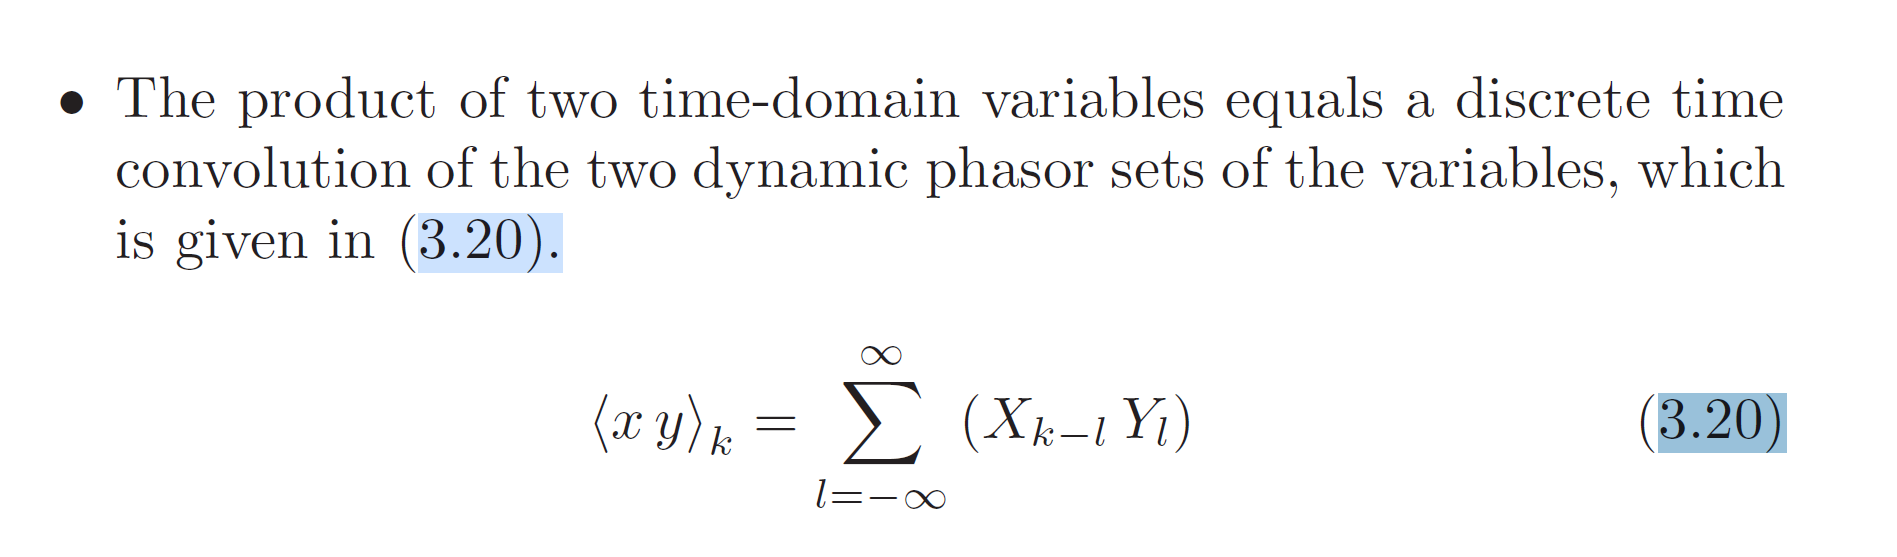

In [ ]:
(lambda_rq *  i_rd - lambda_rd * i_rq)

lambda_rq2*conj(i_rd2) +  lambda_rq0*i_rd0 + conj(lambda_rq2)*i_rd2 -lambda_rd2*conj(i_rd2)-  lambda_rq0*i_rd0 + conj(lambda_rq2)*i_rd2  

In [219]:
var1 = 'lambda_rq'
var2 = 'i_rd'

def dynph_conv(var1,var2,h_list,k):
    eq = 0
    H_1 = [-h for h in h_list]
    H_2 = H_1.copy()
    H_1.reverse()
    H_list =  H_1 + h_list
    H_list = list(dict.fromkeys(H_list))
    
    for l in H_list:
        m = k - l
        sym1r,sym1i = sym.symbols(f'{var1}{np.abs(m)}r,{var1}{np.abs(m)}i', real=True)
        sym2r,sym2i = sym.symbols(f'{var2}{np.abs(l)}r,{var2}{np.abs(l)}i', real=True)
        sym1 = sym1r + sym.I*sym1i
        sym2 = sym2r + sym.I*sym2i

        if m <= H_list[-1]:
            if m < 0:
                eq += sym.conjugate(sym1)*sym2
            elif l < 0:
                eq += sym1*sym.conjugate(sym2) 
            else:
                eq += sym1*sym2 
           
            
    return eq
    

In [220]:
xy = dynph_conv('x','y',[0,2],0) 
sym.im(xy)
xy

(I*x0i + x0r)*(I*y0i + y0r) + (-I*x2i + x2r)*(I*y2i + y2r) + (I*x2i + x2r)*(-I*y2i + y2r)

<div>
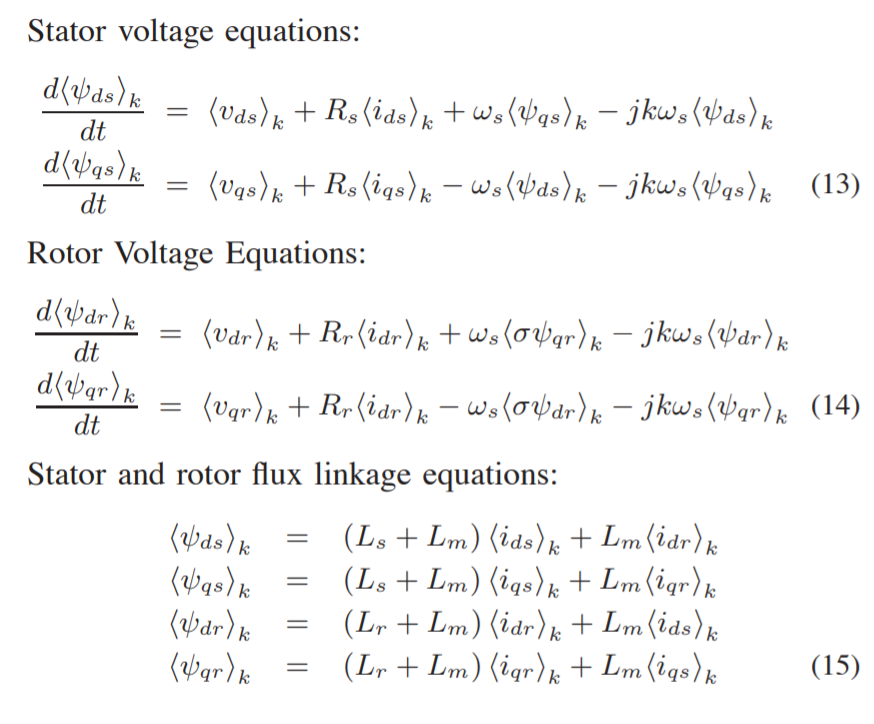
</div>

In [210]:
# im:
L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i = sym.symbols('L_m,R_s,L_ls,R_r,L_lr,N_pp,J_r,B_r,K_p,K_i', real=True)
omega,K_theta,tau_l = sym.symbols('omega,K_theta,tau_l', real=True) 

tau_r0r,tau_r0i,tau_r2r,tau_r2i = sym.symbols('tau_r0r,tau_r0i,tau_r2r,tau_r2i',real=True)
omega_r0r,omega_r0i,omega_r2r,omega_r2i = sym.symbols('omega_r0r,omega_r0i,omega_r2r,omega_r2i',real=True)
omega_r0 = omega_r0r + 1j*omega_r0i
omega_r2 = omega_r2r + 1j*omega_r2i

lambda_sd0r,lambda_sq0r,lambda_rd0r,lambda_rq0r = sym.symbols('lambda_sd0r,lambda_sq0r,lambda_rd0r,lambda_rq0r', real=True)
lambda_sd0i,lambda_sq0i,lambda_rd0i,lambda_rq0i = sym.symbols('lambda_sd0i,lambda_sq0i,lambda_rd0i,lambda_rq0i', real=True)
lambda_sd0 = lambda_sd0r + sym.I*lambda_sd0i
lambda_sq0 = lambda_sq0r + sym.I*lambda_sq0i
lambda_rd0 = lambda_rd0r + sym.I*lambda_rd0i
lambda_rq0 = lambda_rq0r + sym.I*lambda_rq0i
v_sd0r,v_sq0r,v_rd0r,v_rq0r = sym.symbols('v_sd0r,v_sq0r,v_rd0r,v_rq0r', real=True)
v_sd0i,v_sq0i,v_rd0i,v_rq0i = sym.symbols('v_sd0i,v_sq0i,v_rd0i,v_rq0i', real=True)
v_sd0 = v_sd0r + sym.I*v_sd0i
v_sq0 = v_sq0r + sym.I*v_sq0i
v_rd0 = v_rd0r + sym.I*v_rd0i
v_rq0 = v_rq0r + sym.I*v_rq0i
i_sd0r,i_sq0r,i_rd0r,i_rq0r = sym.symbols('i_sd0r,i_sq0r,i_rd0r,i_rq0r', real=True)
i_sd0i,i_sq0i,i_rd0i,i_rq0i = sym.symbols('i_sd0i,i_sq0i,i_rd0i,i_rq0i', real=True)
i_sd0 = i_sd0r + sym.I*i_sd0i
i_sq0 = i_sq0r + sym.I*i_sq0i
i_rd0 = i_rd0r + sym.I*i_rd0i
i_rq0 = i_rq0r + sym.I*i_rq0i
lambda_sd2r,lambda_sq2r,lambda_rd2r,lambda_rq2r = sym.symbols('lambda_sd2r,lambda_sq2r,lambda_rd2r,lambda_rq2r', real=True)
lambda_sd2i,lambda_sq2i,lambda_rd2i,lambda_rq2i = sym.symbols('lambda_sd2i,lambda_sq2i,lambda_rd2i,lambda_rq2i', real=True)
lambda_sd2 = lambda_sd2r + sym.I*lambda_sd2i
lambda_sq2 = lambda_sq2r + sym.I*lambda_sq2i
lambda_rd2 = lambda_rd2r + sym.I*lambda_rd2i
lambda_rq2 = lambda_rq2r + sym.I*lambda_rq2i
v_sd2r,v_sq2r,v_rd2r,v_rq2r = sym.symbols('v_sd2r,v_sq2r,v_rd2r,v_rq2r', real=True)
v_sd2i,v_sq2i,v_rd2i,v_rq2i = sym.symbols('v_sd2i,v_sq2i,v_rd2i,v_rq2i', real=True)
v_sd2 = v_sd2r + sym.I*v_sd2i
v_sq2 = v_sq2r + sym.I*v_sq2i
v_rd2 = v_rd2r + sym.I*v_rd2i
v_rq2 = v_rq2r + sym.I*v_rq2i
i_sd2r,i_sq2r,i_rd2r,i_rq2r = sym.symbols('i_sd2r,i_sq2r,i_rd2r,i_rq2r', real=True)
i_sd2i,i_sq2i,i_rd2i,i_rq2i = sym.symbols('i_sd2i,i_sq2i,i_rd2i,i_rq2i', real=True)
i_sd2 = i_sd2r + sym.I*i_sd2i
i_sq2 = i_sq2r + sym.I*i_sq2i
i_rd2 = i_rd2r + sym.I*i_rd2i
i_rq2 = i_rq2r + sym.I*i_rq2i

lambda_sd0 = lambda_sd0r + sym.I*lambda_sd0i
lambda_sq0 = lambda_sq0r + sym.I*lambda_sq0i
lambda_rd0 = lambda_rd0r + sym.I*lambda_rd0i
lambda_rq0 = lambda_rq0r + sym.I*lambda_rq0i
lambda_sd2 = lambda_sd2r + sym.I*lambda_sd2i
lambda_sq2 = lambda_sq2r + sym.I*lambda_sq2i
lambda_rd2 = lambda_rd2r + sym.I*lambda_rd2i
lambda_rq2 = lambda_rq2r + sym.I*lambda_rq2i

L_s  =  L_m + L_ls
L_r  =  L_m + L_lr

#i_sd0 = (L_m * lambda_rd0 - L_r * lambda_sd0)/(L_m**2 - L_r * L_s)
#i_sq0 = (L_m * lambda_rq0 - L_r * lambda_sq0)/(L_m**2 - L_r * L_s)
#i_rd0 = (L_m * lambda_sd0 - L_s * lambda_rd0)/(L_m**2 - L_r * L_s)
#i_rq0 = (L_m * lambda_sq0 - L_s * lambda_rq0)/(L_m**2 - L_r * L_s)

eq_i_sd0 = -lambda_sd0 + L_s * i_sd0 + L_m * i_rd0 
eq_i_sq0 = -lambda_sq0 + L_s * i_sq0 + L_m * i_rq0 
eq_i_rd0 = -lambda_rd0 + L_r * i_rd0 + L_m * i_sd0 
eq_i_rq0 = -lambda_rq0 + L_r * i_rq0 + L_m * i_sq0 

eq_i_sd2 = -lambda_sd2 + L_s * i_sd2 + L_m * i_rd2
eq_i_sq2 = -lambda_sq2 + L_s * i_sq2 + L_m * i_rq2
eq_i_rd2 = -lambda_rd2 + L_r * i_rd2 + L_m * i_sd2
eq_i_rq2 = -lambda_rq2 + L_r * i_rq2 + L_m * i_sq2

'''
dlambda_sd0 = v_sd - R_s * i_sd + omega * lambda_sq
dlambda_sq0 = v_sq - R_s * i_sq - omega * lambda_sd
dlambda_rd0 = -R_r * i_rd + (omega - omega_e) * lambda_rq 
dlambda_rq0 = -R_r * i_rq - (omega - omega_e) * lambda_rd
'''
I = sym.I

conv_lod = (I*lambda_rq0i + lambda_rq0r)*(I*omega_r0i + omega_r0r) + (-I*lambda_rq2i + lambda_rq2r)*(I*omega_r2i + omega_r2r) + (I*lambda_rq2i + lambda_rq2r)*(-I*omega_r2i + omega_r2r)
conv_loq = (I*lambda_rd0i + lambda_rd0r)*(I*omega_r0i + omega_r0r) + (-I*lambda_rd2i + lambda_rd2r)*(I*omega_r2i + omega_r2r) + (I*lambda_rd2i + lambda_rd2r)*(-I*omega_r2i + omega_r2r)
dlambda_sd0 = v_sd0 - R_s * i_sd0 + omega * lambda_sq0
dlambda_sq0 = v_sq0 - R_s * i_sq0 - omega * lambda_sd0
dlambda_rd0 =       - R_r * i_rd0 + (omega* lambda_rq0 - N_pp*dynph_conv('omega_r','lambda_rq',[0,2],0)) 
dlambda_rq0 =       - R_r * i_rq0 - (omega* lambda_rd0 - N_pp*dynph_conv('omega_r','lambda_rd',[0,2],0)) 


conv_lod = (I*lambda_rq0i + lambda_rq0r)*(I*omega_r2i + omega_r2r) + (I*lambda_rq2i + lambda_rq2r)*(I*omega_r0i + omega_r0r)
conv_loq = (I*lambda_rd0i + lambda_rd0r)*(I*omega_r2i + omega_r2r) + (I*lambda_rd2i + lambda_rd2r)*(I*omega_r0i + omega_r0r)
dlambda_sd2 = v_sd2 - R_s * i_sd2 + omega * lambda_sq2 - sym.I*2*omega*lambda_sd2
dlambda_sq2 = v_sq2 - R_s * i_sq2 - omega * lambda_sd2 - sym.I*2*omega*lambda_sq2
dlambda_rd2 =       - R_r * i_rd2 + (omega* lambda_rq2 - N_pp*conv_lod)  - sym.I*2*omega*lambda_rd2
dlambda_rq2 =       - R_r * i_rq2 - (omega* lambda_rd2 - N_pp*conv_loq)  - sym.I*2*omega*lambda_rq2

# 3/2* N_pp * (lambda_sd *  i_sq - lambda_sq * i_sd)

tau_r0 = tau_r0r + 1j*tau_r0i
tau_r2 = tau_r2r + 1j*tau_r2i

i_sd0r,i_sd0i = sym.re(i_sd0),sym.im(i_sd0)
i_sq0r,i_sq0i = sym.re(i_sq0),sym.im(i_sq0)
i_rd0r,i_rd0i = sym.re(i_rd0),sym.im(i_rd0)
i_rq0r,i_rq0i = sym.re(i_rq0),sym.im(i_rq0)

i_sd2r,i_sd2i = sym.re(i_sd2),sym.im(i_sd2)
i_sq2r,i_sq2i = sym.re(i_sq2),sym.im(i_sq2)
i_rd2r,i_rd2i = sym.re(i_rd2),sym.im(i_rd2)
i_rq2r,i_rq2i = sym.re(i_rq2),sym.im(i_rq2)

#conv_tau_r0 = -(I*i_sd0i + i_sd0r)*(I*lambda_sq0i + lambda_sq0r) - (-I*i_sd2i + i_sd2r)*(I*lambda_sq2i + lambda_sq2r) - (I*i_sd2i + i_sd2r)*(-I*lambda_sq2i + lambda_sq2r) + (I*i_sq0i + i_sq0r)*(I*lambda_sd0i + lambda_sd0r) + (-I*i_sq2i + i_sq2r)*(I*lambda_sd2i + lambda_sd2r) + (I*i_sq2i + i_sq2r)*(-I*lambda_sd2i + lambda_sd2r)
#conv_tau_r2 = -(I*i_sd0i + i_sd0r)*(I*lambda_sq2i + lambda_sq2r) - (I*i_sd2i + i_sd2r)*(I*lambda_sq0i + lambda_sq0r) + (I*i_sq0i + i_sq0r)*(I*lambda_sd2i + lambda_sd2r) + (I*i_sq2i + i_sq2r)*(I*lambda_sd0i + lambda_sd0r)
#eq_tau_r0 = -tau_r0 + 3/2 * N_pp *(dynph_conv('lambda_sd','i_sq',[0,2],0) - dynph_conv('lambda_sq','i_sd',[0,2],0))
#eq_tau_r0 = -tau_r0 + 3/8 * N_pp *(dynph_conv('lambda_rq','i_rd',[0,2],0) - dynph_conv('lambda_rd','i_rq',[0,2],0))
tau_r0r_ = 1.5*N_pp*(-i_rd0i*lambda_rq0i + i_rd0r*lambda_rq0r + i_rd2i*lambda_rq2i/2 + i_rd2r*lambda_rq2r/2 + i_rq0i*lambda_rd0i - i_rq0r*lambda_rd0r - i_rq2i*lambda_rd2i/2 - i_rq2r*lambda_rd2r/2) - tau_r0r
tau_r0i_ = 1.5*N_pp*(i_rd0i*lambda_rq0r + i_rd0r*lambda_rq0i - i_rq0i*lambda_rd0r - i_rq0r*lambda_rd0i) - 1.0*tau_r0i
eq_tau_r0 = tau_r0r_ + I*tau_r0i_
eq_tau_r2 = -tau_r2 + 3/2 * N_pp *(dynph_conv('lambda_sd','i_sq',[0,2],2) - dynph_conv('lambda_sq','i_sd',[0,2],2))

eq_tau_r0r = sym.re(eq_tau_r0)
eq_tau_r0i = sym.im(eq_tau_r0)
eq_tau_r2r = sym.re(eq_tau_r2)
eq_tau_r2i = sym.im(eq_tau_r2)

# mech
domega_r0 = 1/J_r*(tau_r0 - B_r*omega_r0 - tau_l)
domega_r2 = 1/J_r*(tau_r2 - B_r*omega_r2) - sym.I*2*omega*omega_r2

re = sym.re
im = sym.im

u_ini_dict = {'v_sd0r':0.0,'v_sd0i':0.0,'v_sq0r':0.0,'v_sq0i':0.0,
              'v_sd2r':0.0,'v_sd2i':0.0,'v_sq2r':0.0,'v_sq2i':0.0,
              'tau_l':0,'omega':0}  # for the initialization problem
u_run_dict = u_ini_dict  # for the running problem (here initialization and running problem are the same)


f_list = [re(dlambda_sd0),re(dlambda_sq0),re(dlambda_rd0),re(dlambda_rq0),re(domega_r0),
          im(dlambda_sd0),im(dlambda_sq0),im(dlambda_rd0),im(dlambda_rq0),im(domega_r0),
          re(dlambda_sd2),re(dlambda_sq2),re(dlambda_rd2),re(dlambda_rq2),re(domega_r2),
          im(dlambda_sd2),im(dlambda_sq2),im(dlambda_rd2),im(dlambda_rq2),im(domega_r2)]
x_list = [    lambda_sd0r,    lambda_sq0r,    lambda_rd0r,    lambda_rq0r,    omega_r0r,
              lambda_sd0i,    lambda_sq0i,    lambda_rd0i,    lambda_rq0i,    omega_r0i,
              lambda_sd2r,    lambda_sq2r,    lambda_rd2r,    lambda_rq2r,    omega_r2r,
              lambda_sd2i,    lambda_sq2i,    lambda_rd2i,    lambda_rq2i,    omega_r2i]



g_list = [re(eq_i_sd0),re(eq_i_sq0),re(eq_i_rd0),re(eq_i_rq0),
          im(eq_i_sd0),im(eq_i_sq0),im(eq_i_rd0),im(eq_i_rq0),
          re(eq_i_sd2),re(eq_i_sq2),re(eq_i_rd2),re(eq_i_rq2),
          im(eq_i_sd2),im(eq_i_sq2),im(eq_i_rd2),im(eq_i_rq2),
          eq_tau_r0r,eq_tau_r0i,eq_tau_r2r,eq_tau_r2i]

y_list = [i_sd0r,i_sq0r,i_rd0r,i_rq0r,
          i_sd0i,i_sq0i,i_rd0i,i_rq0i,
          i_sd2r,i_sq2r,i_rd2r,i_rq2r,
          i_sd2i,i_sq2i,i_rd2i,i_rq2i,
          tau_r0r,   tau_r0i,   tau_r2r,   tau_r2i]

tau_r0 = tau_r0r + 1j*tau_r0i
tau_r2 = tau_r2r + 1j*tau_r2i

tau_r = sym.re(tau_r0 + tau_r2*sym.exp(1j*2*omega))
omega_r = sym.re(omega_r0 + omega_r2*sym.exp(1j*2*omega))
i_sd =  sym.re(i_sd0 + i_sd2*sym.exp(1j*2*omega))
i_sq =  sym.re(i_sq0 + i_sq2*sym.exp(1j*2*omega))

h_dict = {'tau_b':B_r*omega_r0r,'tau_r':tau_r,'i_sd':i_sd,'i_sq':i_sq,
'v_sd0r':v_sd0r,'v_sq0r':v_sq0r,
'v_sd0i':v_sd0i,'v_sq0i':v_sq0i,
'v_sd2r':v_sd2r,'v_sq2r':v_sq2r,
'v_sd2i':v_sd2i,'v_sq2i':v_sq2i}

In [208]:
sys = {'name':f"im_dp",
       'params_dict':params_dict,
       'f_list':f_list,
       'g_list':g_list,
       'x_list':x_list,
       'y_ini_list':y_list,
       'y_run_list':y_list,
       'u_run_dict':u_run_dict,
       'u_ini_dict':u_ini_dict,
       'h_dict':h_dict
      }

bldr = db.builder(sys)
bldr.build()

Compilation time: 3.62 s


In [214]:
sym.re(dynph_conv('omega_r','lambda_rq',[0,2],0))

-lambda_rq0i*omega_r0i + lambda_rq0r*omega_r0r + 2*lambda_rq2i*omega_r2i + 2*lambda_rq2r*omega_r2r

In [215]:
sym.im(dynph_conv('omega_r','lambda_rq',[0,2],0))

lambda_rq0i*omega_r0r + lambda_rq0r*omega_r0i

In [196]:
str(sym.im(eq_tau_r0))

'0.375*N_pp*(i_rd0i*lambda_rq0r + i_rd0r*lambda_rq0i - i_rq0i*lambda_rd0r - i_rq0r*lambda_rd0i) - 1.0*tau_r0i'

In [211]:
f_list

[-R_s*i_sd0r + lambda_sq0r*omega + v_sd0r,
 -R_s*i_sq0r - lambda_sd0r*omega + v_sq0r,
 -N_pp*(-lambda_rq0i*omega_r0i + lambda_rq0r*omega_r0r + 2*lambda_rq2i*omega_r2i + 2*lambda_rq2r*omega_r2r) - R_r*i_rd0r + lambda_rq0r*omega,
 N_pp*(-lambda_rd0i*omega_r0i + lambda_rd0r*omega_r0r + 2*lambda_rd2i*omega_r2i + 2*lambda_rd2r*omega_r2r) - R_r*i_rq0r - lambda_rd0r*omega,
 (-B_r*omega_r0r - tau_l + tau_r0r)/J_r,
 -R_s*i_sd0i + lambda_sq0i*omega + v_sd0i,
 -R_s*i_sq0i - lambda_sd0i*omega + v_sq0i,
 -N_pp*(lambda_rq0i*omega_r0r + lambda_rq0r*omega_r0i) - R_r*i_rd0i + lambda_rq0i*omega,
 N_pp*(lambda_rd0i*omega_r0r + lambda_rd0r*omega_r0i) - R_r*i_rq0i - lambda_rd0i*omega,
 (-1.0*B_r*omega_r0i + 1.0*tau_r0i)/J_r,
 -R_s*i_sd2r + 2*lambda_sd2i*omega + lambda_sq2r*omega + v_sd2r,
 -R_s*i_sq2r - lambda_sd2r*omega + 2*lambda_sq2i*omega + v_sq2r,
 -N_pp*(-lambda_rq0i*omega_r2i + lambda_rq0r*omega_r2r - lambda_rq2i*omega_r0i + lambda_rq2r*omega_r0r) - R_r*i_rd2r + 2*lambda_rd2i*omega + lambda_rq2r*ome

In [172]:
dynph_conv('lambda_sd','i_sq',[0,2],2)

(I*i_sq0i + i_sq0r)*(I*lambda_sd2i + lambda_sd2r) + (I*i_sq2i + i_sq2r)*(I*lambda_sd0i + lambda_sd0r)

i_rd0i*lambda_rq0i - i_rd0r*lambda_rq0r - 2*i_rd2i*lambda_rq2i - 2*i_rd2r*lambda_rq2r - i_rq0i*lambda_rd0i + i_rq0r*lambda_rd0r + 2*i_rq2i*lambda_rd2i + 2*i_rq2r*lambda_rd2r

In [ ]:
-i_sd0*l_sq0 - conj(i_sd2)*l_sq2 - i_sd2*conj(l_sq2) +  + conj(i_sq2)*l_sd2 + i_sq2*conj(l_sd2)

In [ ]:
i_sq0*l_sd0 + 

In [62]:
omega_e = N_pp*omega_r

sigma_0 = (omega_s - omega_r0)/omega_s



sigma_2 = (omega_s - omega_r2)/omega_s

dlambda_sd2 = v_sd2 - R_s * i_sd2 + omega * lambda_sq2 - 
dlambda_sq2 = v_sq2 - R_s * i_sq2 - omega * lambda_sd2
dlambda_rd2 = -R_r * i_rd2 + (omega - omega_e) * lambda_rq2 
dlambda_rq2 = -R_r * i_rq2 - (omega - omega_e) * lambda_rd2

eq_tau_r0 = -tau_r0 + 3/2* N_pp * (lambda_sd0 *  i_sq0 - lambda_sq0 * i_sd0)
eq_tau_r2 = -tau_r2 + 3/2* N_pp * (lambda_sd2 *  i_sq2 - lambda_sq2 * i_sd2)

#eq_v_sd = -tau_r + 3/2* N_pp * (lambda_sd *  i_sq - lambda_sq * i_sd)
#eq_v_sq = 

# mech:
domega_r = 1/J_r*(tau_r - B_r*omega_r - tau_l)

i_sa = sym.cos(theta)*i_sd + sym.sin(theta)*i_sq
i_sb = sym.cos(theta-2/3*np.pi)*i_sd + sym.sin(theta-2/3*np.pi)*i_sq
i_sc = sym.cos(theta-4/3*np.pi)*i_sd + sym.sin(theta-4/3*np.pi)*i_sq

f_list = [dlambda_sd,dlambda_sq,dlambda_rd,dlambda_rq,domega_r,dtheta]
x_list = [ lambda_sd, lambda_sq, lambda_rd, lambda_rq, omega_r, theta]
g_list = [eq_tau_r]
y_list = [   tau_r]

p_s = 3/2*(i_sq*v_sq + i_sd*v_sd)
q_s = 3/2*(i_sd*v_sq - i_sq*v_sd)

h_dict = {'i_sd':i_sd,'i_sq':i_sq,'i_rd':i_rd,'i_rq':i_rq,'i_pk':(i_sd**2+i_sq**2)**0.5,
          'tau_b':B_r*omega_r,'tau_l':tau_l,
         'p_s':p_s,'q_s':q_s,
         'v_sd':v_sd,'v_sq':v_sq,
         'i_sa':i_sa,'i_sb':i_sb,'i_sc':i_sc,
         'v_sa':v_sa,'v_sb':v_sb,'v_sc':v_sc}

[-4, -2, 0]

In [73]:
test_list = [1, 3, 5, 6, 3, 5, 6, 1]
print ("The original list is : " +  str(test_list))
  
# using list comprehension
# to remove duplicated 
# from list 
res = []
[res.append(x) for x in test_list if x not in res]

The original list is : [1, 3, 5, 6, 3, 5, 6, 1]


[None, None, None, None]

In [75]:
mylist = ["a", "b", "a", "c", "c"]


[-4, -2, 0, 2, 4]
